In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt

import os
import pandas as pd
from sklearn.metrics import roc_curve,auc,precision_recall_curve,roc_curve
import keras
from time import time
from sklearn.model_selection import train_test_split


from moe import MixtureOfExpertsLayer

2022-05-08 06:00:06.374644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 06:00:06.374674: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
class moe_model():
    def __init__(self, feature_nums, N_EXPERTS=2, dropout=False, loss="mse", optimize="adam"):
        experts = [Dense(1, "linear") for _ in range(N_EXPERTS)]
        # mixture of linear experts
        mole = MixtureOfExpertsLayer(expert_layers=experts, add_dropout=dropout)
        # build model
        input_layer = Input(shape=(feature_nums,))
        output_layer = mole(input_layer)
        model = Model(inputs=input_layer, outputs=output_layer)
        # tf.keras.optimizers.Adam(learning_rate=LR))
        model.compile(loss=loss, 
                      optimizer=optimize,
                      metrics=["accuracy"])
        
        self.N_EXPERTS=N_EXPERTS
        self.model=model
        self.experts=experts
        self.mole=mole

    def train(self,train_data, val_data=None, plot_expert=False, plot_result=False, epoches=20, verbose=0):
        start_time=time()
        train_X,train_y=train_data
        history=self.model.fit(train_X,train_y, epochs=epoches, verbose=verbose, validation_data=val_data)

        y_pred_train = self.model.predict(train_X)

        end_time=time()
        if plot_expert:
            assert train_X.shape[1]==1, "Only plot expert with 1 feature column dataset"
            y_pred_train = self.model.predict(train_X)
            experts_predict = [expert(train_X).numpy() for expert in self.experts]
            self.plot_expert(train_X, train_y, y_pred_train, experts_predict)        

        if plot_result:
            self.plot_result(history,val_data)
            
        print(f"Time used to train the model: {end_time-start_time}s")
        # if val_data:
        #     val_X,val_y=val_data
            



    def plot_result(self, history,val_data):
        plt.subplots(2,2,figsize = (15,12))
        plt.subplot(2,2,1)
        plt.plot(history.history['loss'], color = 'blue', label = 'train_loss')
        plt.plot(history.history['val_loss'], color = 'red', label = 'val_loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Moe Train result - Loss (mse)")
        plt.legend()

        if "val_accuracy" in history.history:
            plt.subplot(2,2,2)
            plt.plot(history.history['accuracy'], color = 'green', label = 'train_accuracy')
            plt.plot(history.history['val_accuracy'], color = 'yellow', label = 'val_accuracy')
            plt.xlabel("Epochs")
            plt.ylabel("accuracy")
            plt.title("Moe Train result")
            plt.legend()
            
        if val_data:
            plt.subplot(2,2,3)
            
            val_X,val_y=val_data
            y_pred=self.model.predict(val_X)
            FPR,TPR,threshold=roc_curve(val_y.reshape(-1),y_pred.reshape(-1),pos_label=1)
            AUC=auc(FPR,TPR)


            plt.title(f'ROC CURVE (AUC= {AUC:.2f})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.xlim([0.0,1.0])
            plt.ylim([0.0,1.0])
            plt.plot(FPR,TPR)
            plt.plot([0, 1], [0, 1], color='m', linestyle='--')
            plt.legend()
            
            
            plt.subplot(2,2,4)
            plt.title('PR curve')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.xlim([0.0,1.0])
            plt.ylim([0.0,1.0])            
            
            y_pred=self.model.predict(val_X)
            
            
            precision,recall,thresholds = precision_recall_curve(val_y,y_pred.reshape(-1))
            plt.plot(recall,precision)
                
                
            
        plt.show()

        
    def plot_expert(self, data_X, data_y,pred_y, experts_predict):
        # plot aggregated Model / experts  and targets
        colors = ["r-", "b-", "g-", "k-", "y-"]
        plt.figure(self.N_EXPERTS, figsize=(18, 9))
        for i, expert_pred in enumerate(experts_predict):
            plt.plot(data_X[:, 0], expert_pred[:, 0], colors[i], label=f"expert {i}")
        plt.plot(data_X[:, 0], pred_y[:, 0], "co", label="Predict value")
        plt.plot(data_X[:, 0], data_y[:, 0], "mo", label="Real value")
        plt.xlabel("input range")
        plt.ylabel("Function Value")
        plt.title("Mixture of Linear Experts Demo")
        plt.legend()
        plt.show()

        # plot probabilities assigned to each expert
        expert_probs = self.mole.expert_probs(data_X)
        plt.figure(3, figsize=(18, 9))
        for i in range(len(self.experts)):
            plt.plot(data_X[:, 0], expert_probs[:, i], colors[i])
        plt.xlabel("input range")
        plt.ylabel("Probability")
        plt.title("Expert competence probabilities")

        plt.show()


In [7]:
def get_data(folderpath, label):
    # build synthetic training data
    if os.path.isfile(folderpath):
        dataset_filenemes=[folderpath.split("/")[-1]]
        folderpath="/".join(folderpath.split("/")[:-1])
    else:
        dataset_filenemes=os.listdir(folderpath)
    
    data=pd.read_csv(os.path.join(folderpath,dataset_filenemes[0]))
    data=data.loc[data[label] != -1]
    for file_name in dataset_filenemes[1:]:
        _data=pd.read_csv(os.path.join(folderpath,file_name))
        _data=_data.loc[data[label] != -1]
        data=data.append(_data)
    print(data.columns)        
    dataX, dataY=np.array(data.drop([label],axis=1)), np.array(data[label]).reshape(-1,1)

    return dataX, dataY


In [8]:
x = np.asarray(np.expand_dims(
    np.linspace(-2, 2, 1000), axis=1), dtype=np.float32)
y = 2 * x ** 2 + 1
print(x.shape,y.shape)

(1000, 1) (1000, 1)


Epoch 1/20
32/32 [==============================] - 0s 3ms/step - loss: 20.3852 - accuracy: 0.0000e+00 - val_loss: 20.1123 - val_accuracy: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 0s 1ms/step - loss: 19.8881 - accuracy: 0.0000e+00 - val_loss: 19.6233 - val_accuracy: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 0s 1ms/step - loss: 19.4010 - accuracy: 0.0000e+00 - val_loss: 19.1412 - val_accuracy: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 0s 1ms/step - loss: 18.9250 - accuracy: 0.0000e+00 - val_loss: 18.6688 - val_accuracy: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 0s 1ms/step - loss: 18.4555 - accuracy: 0.0000e+00 - val_loss: 18.2098 - val_accuracy: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 0s 1ms/step - loss: 17.9940 - accuracy: 0.0000e+00 - val_loss: 17.7459 - val_accuracy: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 0s 1ms/step - loss: 17.5289 - accuracy: 0.0000e+

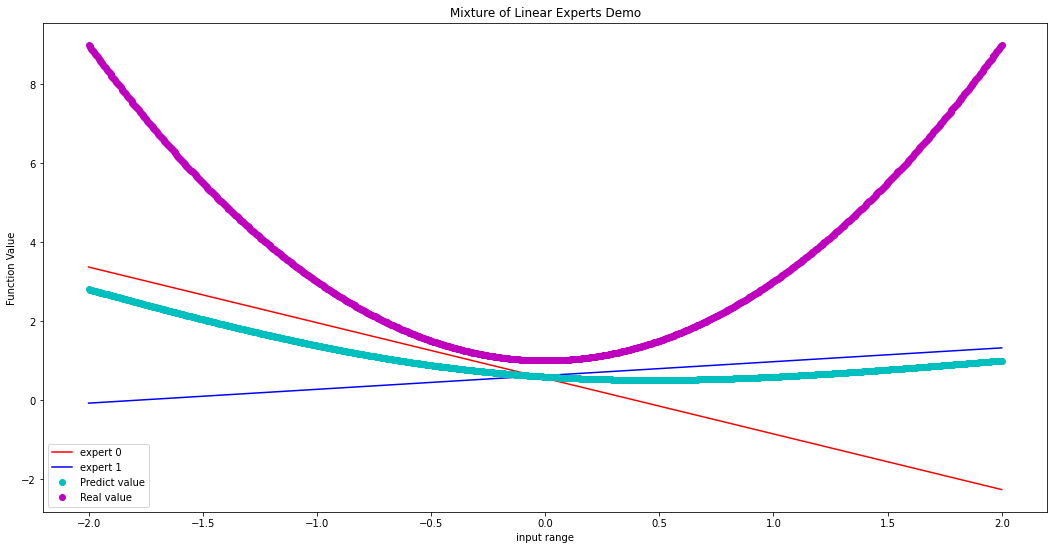

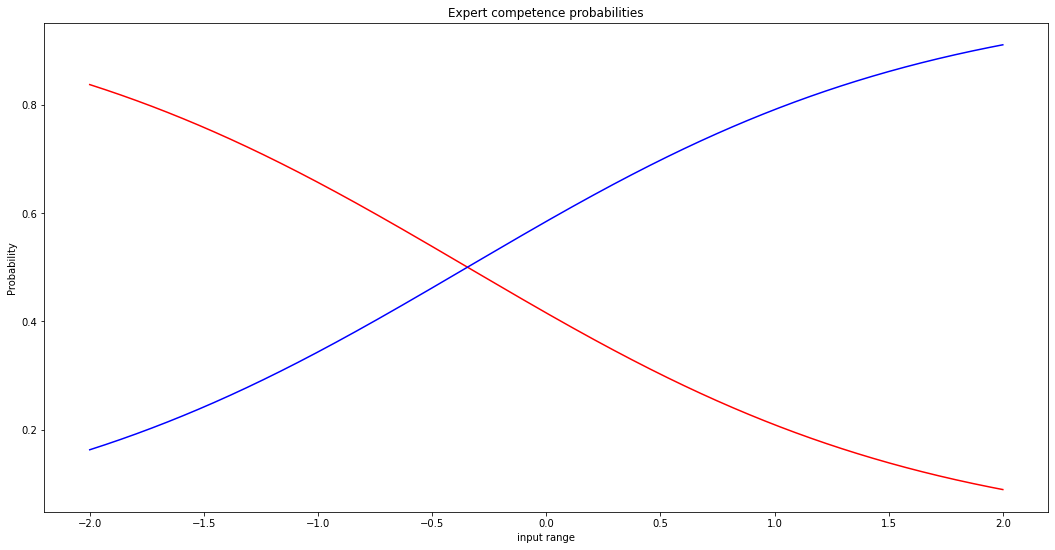

Time used to train the model: 1.2415716648101807s


In [9]:
mm=moe_model(1)
mm.train((x,y),plot_expert=True,plot_result=False,verbose=1, val_data=(x,y))

Index(['age', 'wage_per_hour', 'marital_stat', 'capital_gains',
       'capital_losses', 'stock_dividends', 'instance_weight', 'num_emp',
       'own_or_self', 'vet_benefits',
       ...
       'country_self_ Vietnam', 'country_self_ Yugoslavia',
       'citizenship_ Foreign born- Not a citizen of U S ',
       'citizenship_ Foreign born- U S citizen by naturalization',
       'citizenship_ Native- Born abroad of American Parent(s)',
       'citizenship_ Native- Born in Puerto Rico or U S Outlying',
       'citizenship_ Native- Born in the United States', 'vet_question_ No',
       'vet_question_ Not in universe', 'vet_question_ Yes'],
      dtype='object', length=501)
(199523, 500) (199523, 1)


2022-05-08 04:56:04.467022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-08 04:56:04.467057: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-08 04:56:04.467070: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-94CNSCG): /proc/driver/nvidia/version does not exist
2022-05-08 04:56:04.467338: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
4989/4989 [==============================] - 6s 960us/step - loss: 5147.5688 - accuracy: 0.8286 - val_loss: 0.9402 - val_accuracy: 0.9285
Epoch 2/100
4989/4989 [==============================] - 4s 902us/step - loss: 73.8259 - accuracy: 0.8858 - val_loss: 62.2008 - val_accuracy: 0.9300
Epoch 3/100
4989/4989 [==============================] - 5s 918us/step - loss: 93.4894 - accuracy: 0.8671 - val_loss: 0.2836 - val_accuracy: 0.9319
Epoch 4/100
4989/4989 [==============================] - 4s 875us/step - loss: 108.4404 - accuracy: 0.8128 - val_loss: 318.0699 - val_accuracy: 0.9204
Epoch 5/100
4989/4989 [==============================] - 4s 883us/step - loss: 90.4585 - accuracy: 0.8793 - val_loss: 0.4774 - val_accuracy: 0.9111
Epoch 6/100
4989/4989 [==============================] - 4s 881us/step - loss: 68.0446 - accuracy: 0.8600 - val_loss: 13.2942 - val_accuracy: 0.9161
Epoch 7/100
4989/4989 [==============================] - 4s 870us/step - loss: 78.1159 - accuracy: 0.8752

No handles with labels found to put in legend.


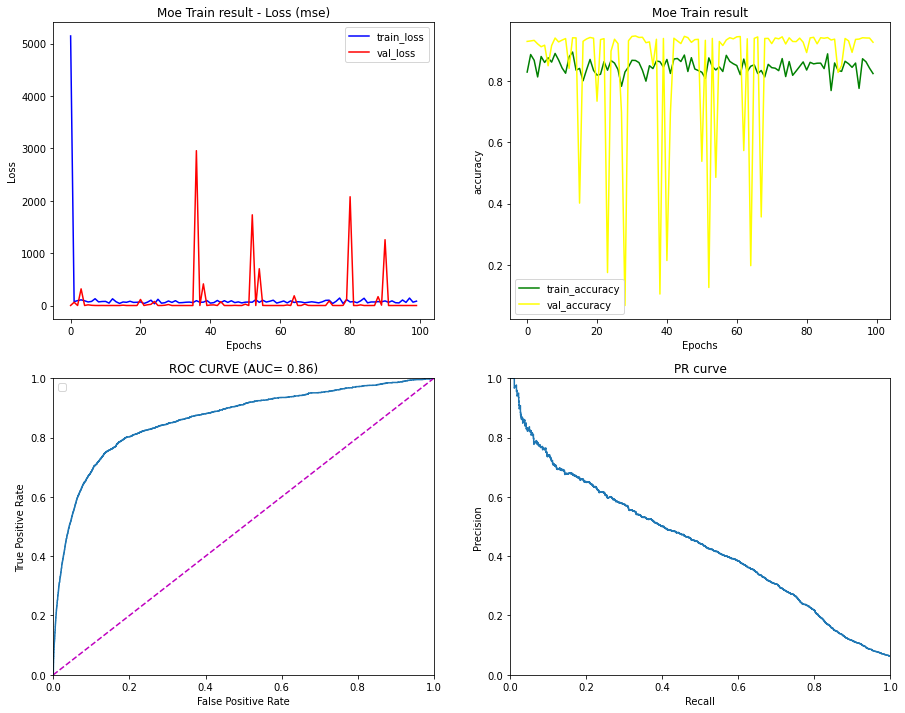

Time used to train the model: 443.6303856372833s


In [4]:
data_X, data_y=get_data("/mnt/w/6998/Project/data/Census-income", "income_50k")
train_X, test_X, train_y, test_y=train_test_split(data_X,data_y,test_size=0.2)
print(data_X.shape, data_y.shape)
mm=moe_model(train_X.shape[1])
mm.train((train_X, train_y),val_data=(test_X,test_y), epoches=100,plot_result=True,verbose=1)

Index(['age', 'wage_per_hour', 'marital_stat', 'capital_gains',
       'capital_losses', 'stock_dividends', 'instance_weight', 'num_emp',
       'own_or_self', 'vet_benefits',
       ...
       'country_self_ Vietnam', 'country_self_ Yugoslavia',
       'citizenship_ Foreign born- Not a citizen of U S ',
       'citizenship_ Foreign born- U S citizen by naturalization',
       'citizenship_ Native- Born abroad of American Parent(s)',
       'citizenship_ Native- Born in Puerto Rico or U S Outlying',
       'citizenship_ Native- Born in the United States', 'vet_question_ No',
       'vet_question_ Not in universe', 'vet_question_ Yes'],
      dtype='object', length=501)
(199523, 500) (199523, 1)
Epoch 1/100
4989/4989 [==============================] - 5s 895us/step - loss: 144.8634 - accuracy: 0.7089 - val_loss: 0.2447 - val_accuracy: 0.8264
Epoch 2/100
4989/4989 [==============================] - 4s 866us/step - loss: 72.1082 - accuracy: 0.8328 - val_loss: 229.8034 - val_accuracy: 0.60

No handles with labels found to put in legend.


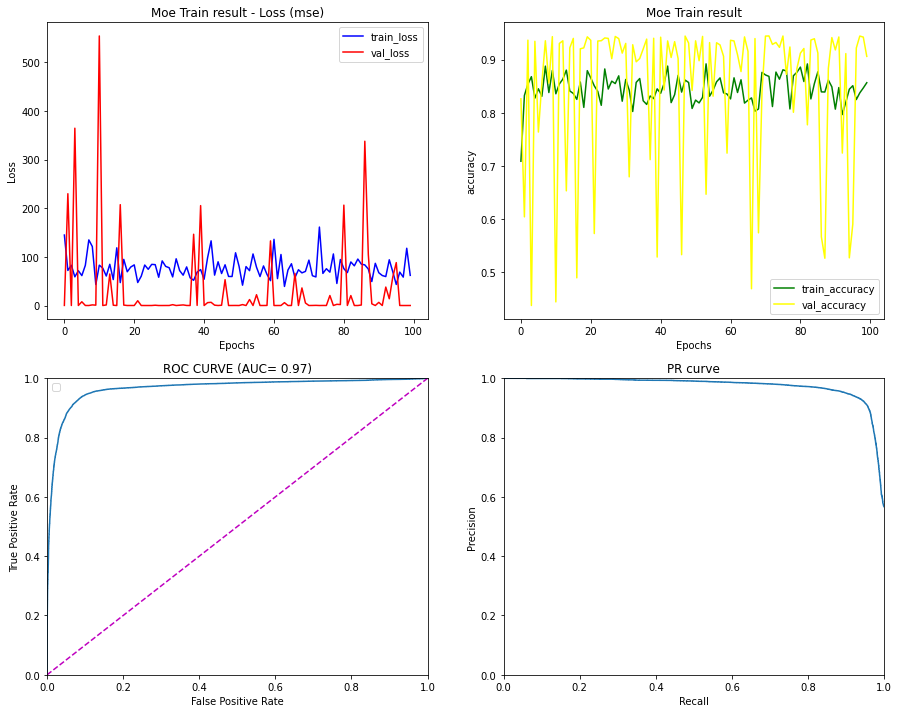

Time used to train the model: 436.2989537715912s


In [27]:
data_X, data_y=get_data("/mnt/w/6998/Project/data/Census-income", "marital_stat")
train_X, test_X, train_y, test_y=train_test_split(data_X,data_y,test_size=0.2)
print(data_X.shape, data_y.shape)
mm=moe_model(train_X.shape[1])
mm.train((train_X, train_y),val_data=(test_X,test_y), epoches=100,plot_result=True,verbose=1)